In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nyse-stockxchange/prices-split-adjusted.csv
/kaggle/input/nyse-stockxchange/fundamentals.csv
/kaggle/input/nyse-stockxchange/prices.csv
/kaggle/input/nyse-stockxchange/securities.csv


In [9]:
BASE_PATH = '/kaggle/input/nyse-stock-market-dataset'


In [10]:
import os
print(os.listdir('/kaggle/input'))


['nyse-stockxchange']


In [11]:
import os
print(os.listdir("/kaggle/input"))


['nyse-stockxchange']


In [12]:
BASE_PATH = "/kaggle/input/nyse-stockxchange"


In [13]:
import pandas as pd

prices = pd.read_csv("/kaggle/input/nyse-stockxchange" + "/prices-split-adjusted.csv")
securities = pd.read_csv("/kaggle/input/nyse-stockxchange" + "/securities.csv")


In [14]:
prices.head()


,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [15]:
# Prepare data
prices['date'] = pd.to_datetime(prices['date'])
prices = prices.sort_values(['symbol', 'date'])

# Calculate daily return
prices['daily_return'] = prices.groupby('symbol')['close'].pct_change()


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
BASE_PATH = "/kaggle/input/nyse-stockxchange"
prices = pd.read_csv(BASE_PATH + "/prices-split-adjusted.csv")
securities = pd.read_csv(BASE_PATH + "/securities.csv")

# Prepare
prices['date'] = pd.to_datetime(prices['date'])
prices = prices.merge(
    securities[['Ticker symbol', 'GICS Sector']],
    left_on='symbol',
    right_on='Ticker symbol',
    how='left'
)

prices = prices.sort_values(['symbol', 'date'])
prices['daily_return'] = prices.groupby('symbol')['close'].pct_change()


In [17]:
sector_metrics = (
    prices.groupby('GICS Sector')
    .agg(
        avg_daily_return=('daily_return', 'mean'),
        volatility=('daily_return', 'std'),
        avg_volume=('volume', 'mean')
    )
    .reset_index()
)

sector_metrics


,GICS Sector,avg_daily_return,volatility,avg_volume
0,Consumer Discretionary,0.000681,0.018912,4.509139e+06
1,Consumer Staples,0.000570,0.013198,4.507772e+06
2,Energy,0.000376,0.023063,5.918965e+06
3,Financials,0.000571,0.017361,7.749111e+06
4,Health Care,0.000707,0.018691,4.069756e+06
5,Industrials,0.000652,0.018181,3.534210e+06
6,Information Technology,0.000656,0.019497,1.035927e+07
7,Materials,0.000506,0.018570,3.747326e+06
8,Real Estate,0.000542,0.015851,2.073531e+06
9,Telecommunications Services,0.000215,0.017813,1.378897e+07


Sector-level aggregation highlights differences in average returns,
risk (volatility), and trading activity across NYSE sectors.


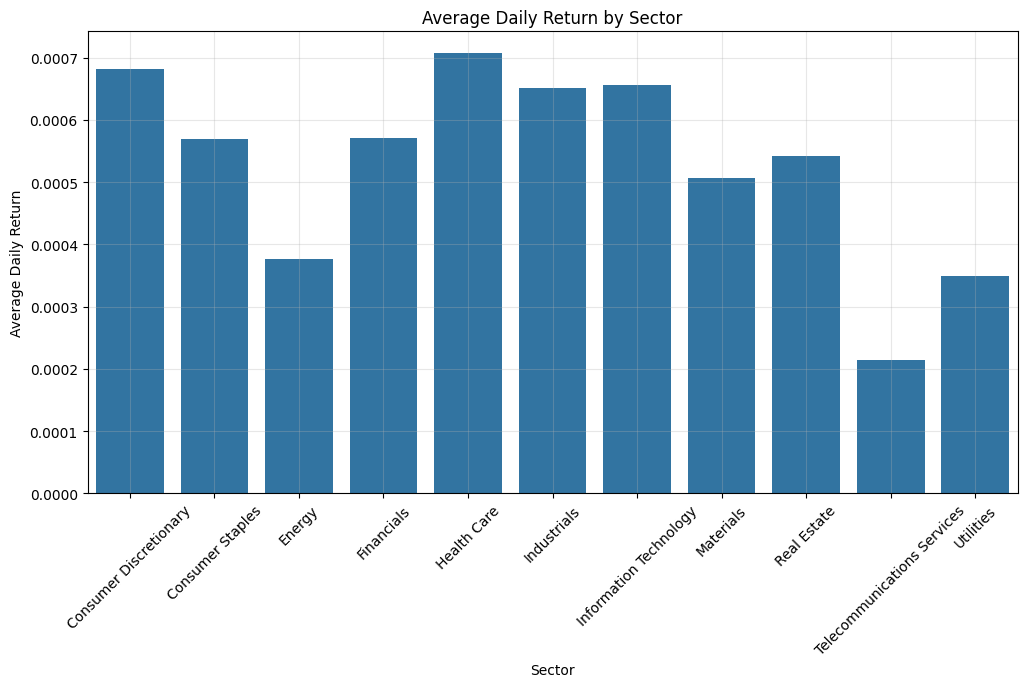

In [18]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=sector_metrics,
    x='GICS Sector',
    y='avg_daily_return'
)
plt.xticks(rotation=45)
plt.title("Average Daily Return by Sector")
plt.xlabel("Sector")
plt.ylabel("Average Daily Return")
plt.grid(alpha=0.3)
plt.show()


Some sectors consistently generate higher average returns,
indicating growth-oriented segments within the market.


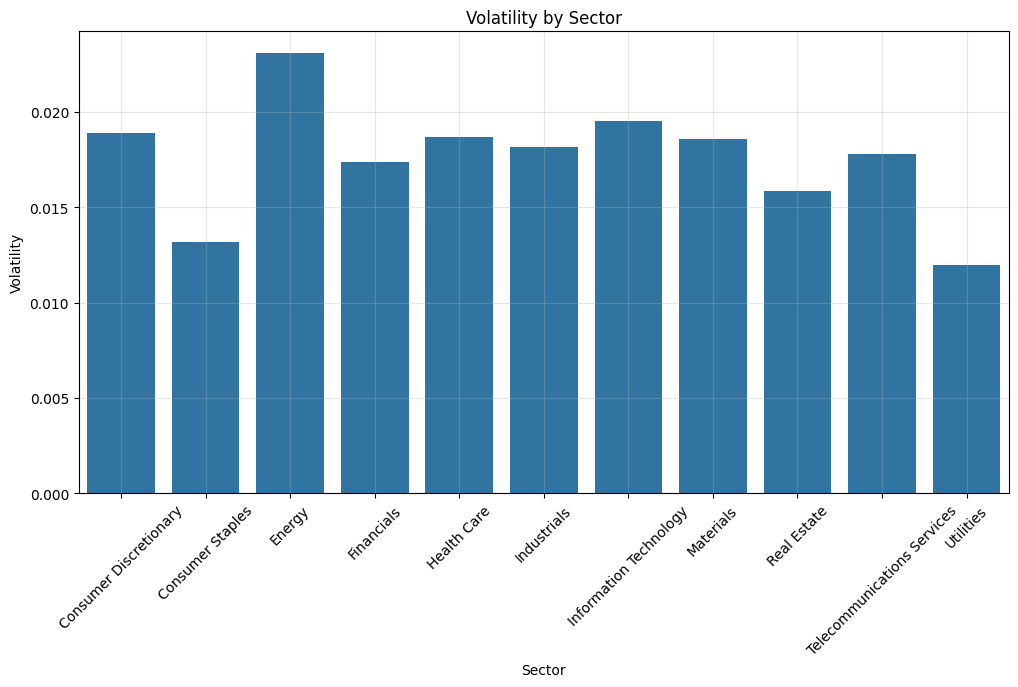

In [19]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=sector_metrics,
    x='GICS Sector',
    y='volatility'
)
plt.xticks(rotation=45)
plt.title("Volatility by Sector")
plt.xlabel("Sector")
plt.ylabel("Volatility")
plt.grid(alpha=0.3)
plt.show()


Higher volatility sectors reflect greater risk and price fluctuations,
while lower volatility sectors indicate more stable investment behavior.


In [20]:
risk_return = (
    prices.groupby('symbol')
    .agg(
        avg_return=('daily_return', 'mean'),
        risk=('daily_return', 'std')
    )
    .reset_index()
)


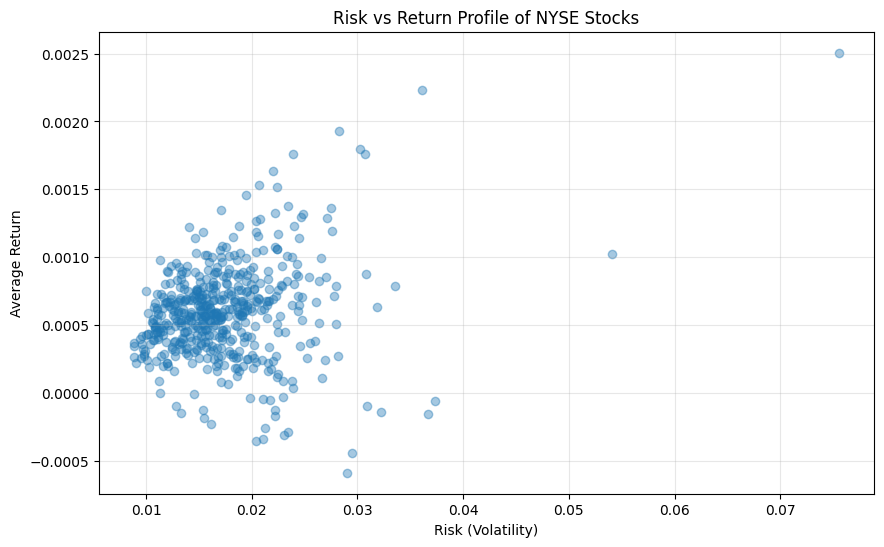

In [21]:
plt.figure(figsize=(10,6))
plt.scatter(
    risk_return['risk'],
    risk_return['avg_return'],
    alpha=0.4
)

plt.xlabel("Risk (Volatility)")
plt.ylabel("Average Return")
plt.title("Risk vs Return Profile of NYSE Stocks")
plt.grid(alpha=0.3)
plt.show()


The scatter plot illustrates the classic risk–return tradeoff:
stocks with higher volatility generally offer higher potential returns.


In [22]:
stable_stocks = risk_return[
    (risk_return['risk'] < risk_return['risk'].quantile(0.25)) &
    (risk_return['avg_return'] > risk_return['avg_return'].quantile(0.50))
]

stable_stocks.head()


,symbol,avg_return,risk
5,ABC,0.000700,0.013233
11,ADP,0.000629,0.010785
27,ALL,0.000591,0.013022
35,AMT,0.000594,0.013350
39,AON,0.000689,0.012360


In [23]:
growth_stocks = risk_return[
    (risk_return['risk'] > risk_return['risk'].quantile(0.75)) &
    (risk_return['avg_return'] > risk_return['avg_return'].quantile(0.75))
]

growth_stocks.head()


,symbol,avg_return,risk
1,AAL,0.001764,0.030713
13,ADSK,0.000835,0.021570
24,AKAM,0.000857,0.025452
26,ALK,0.001533,0.020695
29,ALXN,0.001174,0.022520


The analysis identifies stable low-risk stocks suitable for conservative
strategies, as well as high-growth stocks offering higher returns with
increased risk.


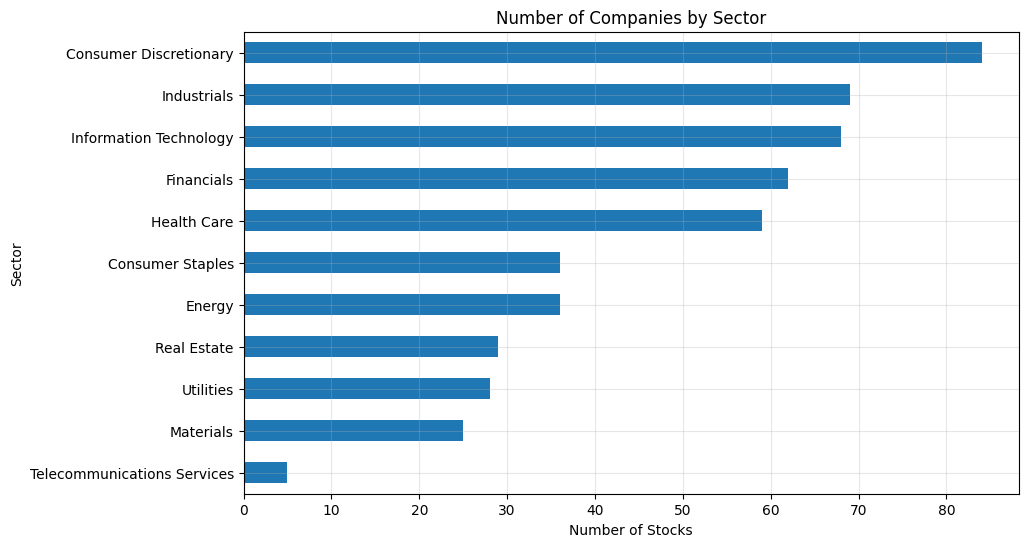

In [24]:
sector_count = prices.groupby('GICS Sector')['symbol'].nunique()

plt.figure(figsize=(10,6))
sector_count.sort_values().plot(kind='barh')
plt.title("Number of Companies by Sector")
plt.xlabel("Number of Stocks")
plt.ylabel("Sector")
plt.grid(alpha=0.3)
plt.show()


Certain sectors dominate the NYSE by number of listed companies,
indicating higher diversification and market representation.


• Performed sector-wise performance analysis and risk–return evaluation on NYSE stocks to identify stable and high-growth investment opportunities using Python

In [25]:
sector_metrics = (
    prices.groupby('GICS Sector')
    .agg(
        avg_daily_return=('daily_return', 'mean'),
        volatility=('daily_return', 'std'),
        avg_volume=('volume', 'mean')
    )
    .reset_index()
)


In [26]:
# ===============================
# MASTER DATA LOADING & PREP CELL
# ===============================

import pandas as pd

# Correct Kaggle dataset path
BASE_PATH = "/kaggle/input/nyse-stockxchange"

# Load datasets
prices = pd.read_csv(BASE_PATH + "/prices-split-adjusted.csv")
securities = pd.read_csv(BASE_PATH + "/securities.csv")

# Prepare data
prices['date'] = pd.to_datetime(prices['date'])

prices = prices.merge(
    securities[['Ticker symbol', 'GICS Sector']],
    left_on='symbol',
    right_on='Ticker symbol',
    how='left'
)

prices = prices.sort_values(['symbol', 'date'])

# Financial metric
prices['daily_return'] = prices.groupby('symbol')['close'].pct_change()

# Sanity check
prices.head()


,date,symbol,open,close,low,high,volume,Ticker symbol,GICS Sector,daily_return
251,2010-01-04,A,22.453504,22.389128,22.267525,22.625180,3815500.0,A,Health Care,NaN
718,2010-01-05,A,22.324749,22.145923,22.002861,22.331903,4186000.0,A,Health Care,-0.010863
1186,2010-01-06,A,22.067240,22.067240,22.002861,22.174536,3243700.0,A,Health Care,-0.003553
1654,2010-01-07,A,22.017168,22.038626,21.816881,22.045780,3095100.0,A,Health Care,-0.001297
2122,2010-01-08,A,21.917024,22.031474,21.745350,22.067240,3733900.0,A,Health Care,-0.000325


In [27]:
sector_metrics = (
    prices.groupby('GICS Sector')
    .agg(
        avg_daily_return=('daily_return', 'mean'),
        volatility=('daily_return', 'std'),
        avg_volume=('volume', 'mean')
    )
    .reset_index()
)

sector_metrics.head()


,GICS Sector,avg_daily_return,volatility,avg_volume
0,Consumer Discretionary,0.000681,0.018912,4.509139e+06
1,Consumer Staples,0.000570,0.013198,4.507772e+06
2,Energy,0.000376,0.023063,5.918965e+06
3,Financials,0.000571,0.017361,7.749111e+06
4,Health Care,0.000707,0.018691,4.069756e+06


In [28]:
risk_return = (
    prices.groupby('symbol')
    .agg(
        avg_return=('daily_return', 'mean'),
        risk=('daily_return', 'std')
    )
    .reset_index()
)

risk_return.head()


,symbol,avg_return,risk
0,A,0.000580,0.018760
1,AAL,0.001764,0.030713
2,AAP,0.000961,0.017214
3,AAPL,0.000893,0.016518
4,ABBV,0.000724,0.017299


In [29]:
sector_metrics.to_csv("sector_metrics.csv", index=False)
risk_return.to_csv("risk_return.csv", index=False)

prices[['date', 'symbol', 'close', 'volume', 'GICS Sector']] \
    .to_csv("prices_dashboard.csv", index=False)


In [30]:
# 1. Sector-level KPIs
sector_metrics.to_csv("sector_metrics.csv", index=False)

# 2. Stock-level risk vs return
risk_return.to_csv("risk_return.csv", index=False)

# 3. Market trend & volume data
prices[['date', 'symbol', 'close', 'volume', 'GICS Sector']] \
    .to_csv("prices_dashboard.csv", index=False)


In [31]:
import os

os.listdir('/kaggle/working')


['.virtual_documents',
 'sector_metrics.csv',
 'prices_dashboard.csv',
 'risk_return.csv']

In [32]:
# Aggregate market-level data (BI friendly)
market_daily = (
    prices.groupby('date')
    .agg(
        avg_close=('close', 'mean'),
        total_volume=('volume', 'sum')
    )
    .reset_index()
)

market_daily.to_csv('/kaggle/working/market_daily.csv', index=False)
